In [2]:
import rebound

In [4]:
sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin")

/home/alchzh/cassum-2022-project-21/workspace/src/rebound/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [15]:
from numpy import sqrt
from itertools import count

for i in count():
    sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin", i)
    p = sim.particles[1]
    print(p.a)

0.23600328174987403
0.23598427014111334
0.23597036755109194
0.23596139637376037
0.23595732289630628
0.23595944642754452
0.23596731089163994
0.23597994118748572
0.23602015132165152
0.23607708237060612
0.23613281030604344
0.23607003783306982
0.23530414893446305
0.23524734122434843
0.2353736727453296
0.23537301494278132
0.23520881318555173
0.23613134493124627


RuntimeError: Index out of range.

t=1.000000, p1: x=-0.148, y=-0.206, r=0.254 AU, vx_gas=10.129, p.vx=10.649, vy_gas=-7.263, p.vy=-5.534, v_gas=12.464, v_rel=1.806, F_d=1.019e-10, F_G=7.294e-04, P_d=2.274632e-10
t=1.000000, p2: x=0.135, y=0.140, r=0.194 AU, vx_gas=-10.264, p.vx=-9.550, vy_gas=9.913, p.vy=12.132, v_gas=14.270, v_rel=2.331, F_d=2.095e-10, F_G=1.897e-03, P_d=-1.807047e-09
t=2.000000, p1: x=-0.251, y=0.100, r=0.270 AU, vx_gas=-4.487, p.vx=-4.869, vy_gas=-11.213, p.vy=-10.063, v_gas=12.077, v_rel=1.211, F_d=4.194e-11, F_G=6.429e-04, P_d=3.361659e-10
t=2.000000, p2: x=0.023, y=-0.218, r=0.219 AU, vx_gas=13.371, p.vx=13.201, vy_gas=1.407, p.vy=4.306, v_gas=13.445, v_rel=2.904, F_d=3.741e-10, F_G=1.495e-03, P_d=-1.318732e-09
t=3.000000, p1: x=0.084, y=0.199, r=0.216 AU, vx_gas=-12.459, p.vx=-12.073, vy_gas=5.257, p.vy=7.194, v_gas=13.523, v_rel=1.975, F_d=1.287e-10, F_G=1.002e-03, P_d=-6.038842e-10
t=3.000000, p2: x=-0.264, y=-0.099, r=0.282 AU, vx_gas=4.128, p.vx=4.640, vy_gas=-11.071, p.vy=-9.511, v_gas=11.8

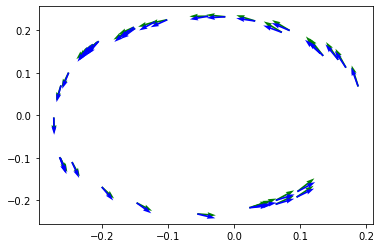

In [115]:
import numpy as np
from amuse.units import units
from scipy.interpolate import interp1d
from itertools import count 
from numpy import sqrt

velocity_file = "../disk/velocity.txt"
density_file = "../disk/midplane_density_2.txt"

C_d = 1.0
G = 4 * np.pi * np.pi

r, vt_gas_cms, vr_gas_cms = np.loadtxt(velocity_file).T
vt_gas = (vt_gas_cms | (units.cm / units.s)).value_in(units.AU / units.yr)
vr_gas = (vr_gas_cms | (units.cm / units.s)).value_in(units.AU / units.yr)

_, rho_0_cms = np.loadtxt(density_file).T
rho_0 = (rho_0_cms | (units.g / units.cm**3)).value_in(units.MSun / (units.AU**3))

interpf = interp1d(r, np.stack([vt_gas, vr_gas, rho_0]))

def mag_dir_2d(x, y):
    r = np.sqrt(x*x + y*y)
    return r, x / r, y / r
    

xl_p = []
yl_p = []
vxl_p = []
vyl_p = []
vxl_gas = []
vyl_gas = []

for i in count():
    try:
        sim = rebound.Simulation("/home/alchzh/cassum-2022-project-21/workspace/sim/simon_simulations_20220613/iopf_sim_DRAG_1.0__ALPHA_-2_BETA_None_0/rebound_archive.bin", i)
    except RuntimeError:
        break

    sun = sim.particles[0]
    # print(f"Sun: v_x={sun.vx}, v_y={sun.vy}")
    for i, p in enumerate(sim.particles[1:]):
        x = p.x
        y = p.y
        # z = p.z

        _r, ux, uy = mag_dir_2d(x, y)

        _vt_gas, _vr_gas, _rho_0 = interpf(_r)

        vx_gas = ux * _vr_gas - uy * _vt_gas
        vy_gas = uy * _vr_gas + ux * _vt_gas

        vx_rel = vx_gas - p.vx
        vy_rel = vy_gas - p.vy

        v_rel, ux_rel, uy_rel = mag_dir_2d(vx_rel, vy_rel)

        A = np.pi * p.r * p.r
        F_d = 0.5 * _rho_0 * v_rel * v_rel * C_d * A

        # p.ax += F_d * ux_rel
        # p.ay += F_d * uy_rel

        print(f"t={sim.t:f}, p{i+1}: {x=:.3f}, {y=:.3f}, r={_r:.3f} AU, {vx_gas=:.3f}, {p.vx=:.3f}, {vy_gas=:.3f}, {p.vy=:.3f}, v_gas={sqrt(vx_gas*vx_gas + vy_gas*vy_gas):.3f}, v_rel={v_rel:.3f}, F_d={F_d:.3e}, F_G={G * p.m * sun.m / (_r * _r):.3e}, P_d={F_d * ux_rel * p.vx + F_d * uy_rel * p.vy:3e}")        
        
        xl_p.append(p.x)
        yl_p.append(p.y)
        vxl_p.append(p.vx)
        vyl_p.append(p.vy)
        vxl_gas.append(vx_gas)
        vyl_gas.append(vy_gas)

import matplotlib.pyplot as plt

plt.quiver(xl_p, yl_p, vxl_p, vyl_p, color="green", width=0.005)
plt.quiver(xl_p, yl_p, vxl_gas, vyl_gas, color="blue", width=0.005)